In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [3]:
os.chdir(Path().resolve().parent)

In [4]:
sessions = ml.sessions.GBYK

In [5]:
poses = dict()
intervals = dict()

for session in sessions:
    poses_dir = Path("data/gbyk/") / session / "poses"
    poses_ = ml.data.load_from_memmap(poses_dir)
    poses_ = ml.poses.change_representation(
        poses_,
        "centered",
        "gbyk",
    )
    poses[session] = poses_

    intervals[session] = dict()
    intervals_dir = Path(f"data/gbyk/{session}/intervals/")
    for i, meta_interval in enumerate(sorted(intervals_dir.iterdir())):
        intervals[session][i] = {
            "side": None,
            "start": None,
            "end": None,
            "type": None,
        }
        with open(meta_interval, "r") as f:
            meta_dict = yaml.safe_load(f)
            start = int(meta_dict["first_frame_idx"] // 50)
            end = start + int(meta_dict["num_frames"] // 50)
            intervals[session][i]["start"] = start
            intervals[session][i]["end"] = end
            intervals[session][i]["side"] = meta_dict["side"]
            intervals[session][i]["type"] = meta_dict["type"]

In [6]:
test = ml.poses.compute_trunk(poses_, "gbyk")
kps_to_exclude = ["r_eye", "r_ear", "l_eye", "l_ear", "nose", "head", "e_tail"]
idxs = [ml.utils.KEYPOINTS["gbyk"][kp] for kp in kps_to_exclude]
test = test.reshape(-1, 21, 3)
test[:, idxs, :] = np.nan
test = test.reshape(-1, 63)

In [7]:
s, e = intervals[session][0]["start"], intervals[session][0]["end"]
ml.plot.poses3d_improved(
    test[s:e],
    "gbyk",
    fps=50,
    save_path="test",
)

Saved interactive plot as HTML: test.html


In [8]:
runs = {
    "allocentric": 20250729190213,
    "centered": 20250729191545,
    "egocentric": 20250729184533,
    "trunk": 20250729193028,
    "head": 20250729195943,
    "pc": 20250729153306,
    "loose": 20250729175541,
    "medium": 20250729180746,
    "strict": 20250729181925,
    "draconian": 20250729183336,
}

In [ ]:
results_dict = {
    "representation": [],
    "monkey": [],
    "type": [],
    # "x_acc": [],
    "acc": [],
    "direction": [],
}

for representation, run in runs.items():
    config_path = Path(f"config/poses_to_position/{run}.yaml")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
        config["dataset"]["entire_trials"] = True
        config["dataset"]["batch_size"] = 1

    test_intervals, train_intervals, _ = ml.intervals.load_by_tiers(
        data_dir=config["data_dir"],
        sessions=config["sessions"],
        experiment=config["experiment"],
        include_trial=config["intervals"]["include_trial"],
        include_homing=config["intervals"]["include_homing"],
        include_sitting=config["intervals"]["include_sitting"],
        balance_intervals=config["intervals"]["balance_intervals"],
        sampling_rate=config["sampling_rate"],
    )

    eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

    for session in config["sessions"]:
        for i in range(len(test_intervals)):
            acc = ml.metrics.mse(
                eval_gts[session]["position"][i],
                eval_preds[session]["position"][i],
            )
            results_dict["representation"].append(representation)
            results_dict["monkey"].append(session[:3])
            results_dict["type"].append(test_intervals[session][i].type)
            results_dict["direction"].append(test_intervals[session][i].side)
            results_dict["acc"].append(acc)

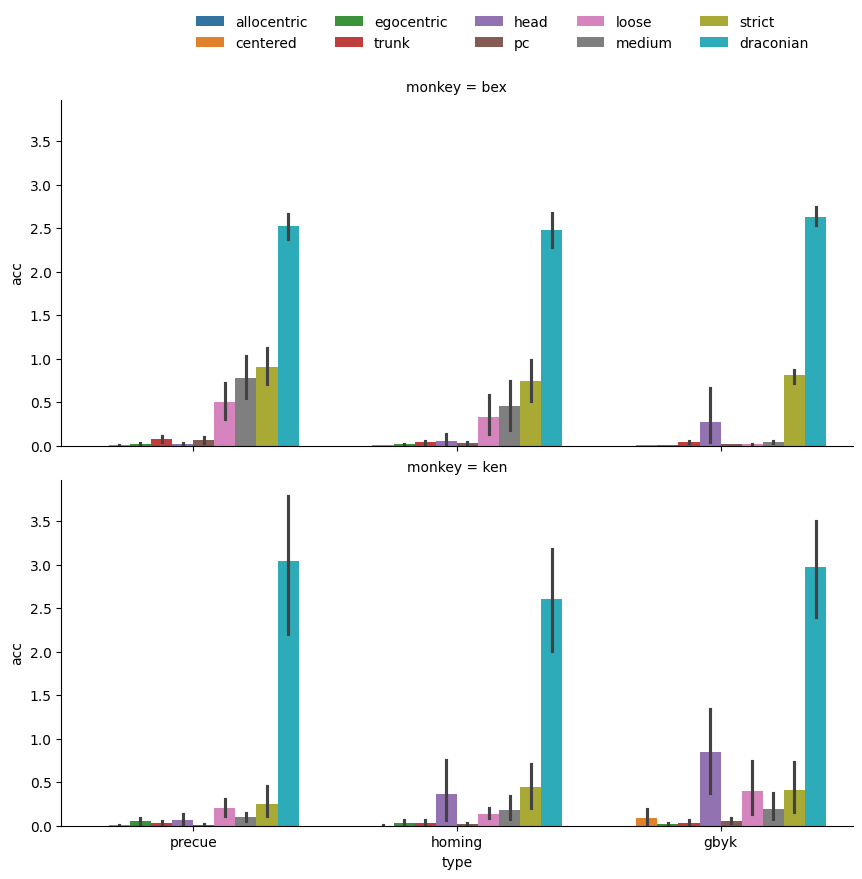

In [51]:
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="acc",
    hue="representation",
    kind="bar",
    col_wrap=1,
    hue_order=list(runs.keys()),
)

g.fig.set_size_inches(12, 8)
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.05),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)